In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import foolbox as fb
import matplotlib.pyplot as plt
from vgg_inference_model import VGG
import sys
sys.path.append("/home/reshikesh/hrushikesh/robust/vgg19/standard")
from vgg_change import VGG as AGG
from PIL import Image

batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
print(device)

cifar_train = datasets.CIFAR10("~/data", train=True, download=True, transform=transforms.ToTensor())
cifar_test = datasets.CIFAR10("~/data", train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(cifar_train, batch_size = batch_size, shuffle=False)
test_loader = DataLoader(cifar_test, batch_size = batch_size, shuffle=True)


classes = ['aeroplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Load the inference model
inf_model = VGG(0.3).to(device)
inf_model.load_state_dict(torch.load("/home/reshikesh/hrushikesh/robust/vgg19/batchout_many/n_3/model_reg_121.pt"))
inf_model.eval()

# Create the foolbox model based on standard vgg. We use this to create adversarial images
preprocessing = dict(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616], axis=-3)

model = AGG()
model.eval()
model.load_state_dict(torch.load("/home/reshikesh/hrushikesh/robust/vgg19/batchout_many/n_3/model_reg_121.pt"))
fmodel = fb.PyTorchModel(model, bounds=(0,1), preprocessing=preprocessing)

# So there are two models now: Inference model which accepts two images and performs batchout and
# Foolbox model that will be used to get adversarial images

cuda
Files already downloaded and verified
Files already downloaded and verified


Predictions of the original image: 
 tensor([[ 0.2506, -0.3000,  0.8366,  0.0407,  0.0416, -0.2429,  0.0585, -0.6466,
          0.1166, -0.3031]], device='cuda:0', grad_fn=<AddmmBackward>)
The image is predicted as 21.68 % bird


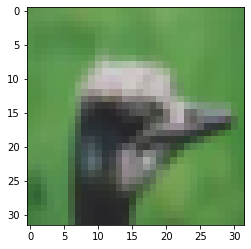

In [2]:
# Choose some random image from test set 
ori_img = Image.open("/home/reshikesh/cifar10_fastai/test/bird/0601.png")
ori_img_class = torch.tensor([2]) # Airplane class is 0
ori_img = transforms.ToTensor()(ori_img)[None, :, :, :]
plt.imshow(ori_img[0].numpy().transpose(1,2,0))

ori_img = ori_img.to(device)
ori_img_class = ori_img_class.to(device)

yp = inf_model(ori_img)
softmax_pred = float(nn.Softmax(dim=1)(yp).max().cpu().detach().numpy() * 100)
print("Predictions of the original image: \n", yp)
print("The image is predicted as {:.2f} % {}".format(softmax_pred, classes[int(yp.argmax())]))

In [3]:
img = ori_img.squeeze()
total_err = 0.
X,y = next(iter(test_loader))
print(y)
for x in X:
    x = x.to(device)    
    images = torch.stack((img, x))
    yp = inf_model(images)
    #print(yp[0])
    total_err += (yp[0].max(dim=0)[1] != ori_img_class).sum().item()
    #print(classes[int(yp[1].argmax())])
print("Error rate is: ", total_err * 100 / 32)

tensor([7, 2, 8, 1, 9, 0, 9, 2, 8, 0, 0, 5, 6, 7, 6, 8, 7, 5, 3, 4, 5, 4, 6, 8,
        6, 7, 8, 2, 7, 3, 1, 4])
Error rate is:  50.0


In [5]:
# Perform the same with FGSM adversarial image
attack = fb.attacks.FGSM()
raw, clipped, is_adv = attack(fmodel, ori_img, ori_img_class, epsilons=[8/255])
fgsm_img = clipped[0]

print("Whether adversarial image is formed, {}".format(str(is_adv.cpu().numpy())))

yp = inf_model(fgsm_img)
softmax_pred = float(nn.Softmax(dim=1)(yp).max().cpu().detach().numpy() * 100)
print("Predictions of the original image: \n", yp)
print("The image is {:.2f} % {}".format(softmax_pred, classes[int(yp.argmax())]))

[tensor([[[[0.3922, 0.4000, 0.4157,  ..., 0.3725, 0.3608, 0.3490],
          [0.3412, 0.3412, 0.3490,  ..., 0.3176, 0.2980, 0.2863],
          [0.3255, 0.3804, 0.3804,  ..., 0.3765, 0.2941, 0.3412],
          ...,
          [0.2078, 0.2706, 0.2314,  ..., 0.3804, 0.3137, 0.3020],
          [0.2275, 0.2431, 0.2588,  ..., 0.3765, 0.3608, 0.3490],
          [0.2902, 0.2431, 0.3255,  ..., 0.3020, 0.3490, 0.3255]],

         [[0.6000, 0.6078, 0.6196,  ..., 0.6078, 0.5922, 0.5216],
          [0.5529, 0.5529, 0.5608,  ..., 0.5529, 0.5373, 0.5255],
          [0.6039, 0.5961, 0.5961,  ..., 0.6118, 0.5255, 0.5765],
          ...,
          [0.4980, 0.4980, 0.4588,  ..., 0.5882, 0.5216, 0.5098],
          [0.5216, 0.5333, 0.5490,  ..., 0.5843, 0.5686, 0.4941],
          [0.5216, 0.5333, 0.5529,  ..., 0.5176, 0.4980, 0.4784]],

         [[0.3333, 0.3451, 0.3569,  ..., 0.2627, 0.3216, 0.2510],
          [0.2824, 0.2863, 0.2902,  ..., 0.3294, 0.2588, 0.2510],
          [0.3333, 0.3294, 0.3294,  ..., 

IndexError: list index out of range

In [61]:
img = fgsm_img.squeeze()
total_err = 0.
predictions = []
X,y = next(iter(test_loader))
print(y)
for x in X:
    x = x.to(device)    
    images = torch.stack((img, x))
    yp = inf_model(images)
    total_err += (yp[0].max(dim=0)[1] != ori_img_class).sum().item()
    predictions.append(classes[int(yp[1].argmax())])
print("\n Error rate is: ", total_err * 100 / 32)
print(predictions)

tensor([0, 9, 2, 9, 0, 2, 8, 1, 2, 2, 8, 8, 1, 6, 2, 2, 6, 1, 1, 7, 5, 3, 7, 7,
        2, 4, 6, 1, 7, 8, 9, 7])

 Error rate is:  53.125
['aeroplane', 'truck', 'bird', 'truck', 'aeroplane', 'bird', 'ship', 'automobile', 'bird', 'bird', 'ship', 'ship', 'automobile', 'frog', 'bird', 'bird', 'bird', 'automobile', 'automobile', 'horse', 'dog', 'cat', 'horse', 'horse', 'deer', 'deer', 'frog', 'automobile', 'horse', 'ship', 'truck', 'horse']


In [62]:
# Perform the same with FGSM adversarial image
attack = fb.attacks.PGD()
raw, clipped, is_adv = attack(fmodel, ori_img, ori_img_class, epsilons=[12/255])
fgsm_img = clipped[0]

print("Whether adversarial image is formed, {}".format(str(is_adv.cpu().numpy())))

yp = inf_model(fgsm_img)
softmax_pred = float(nn.Softmax(dim=1)(yp).max().cpu().detach().numpy() * 100)
print("Predictions of the original image: \n", yp)
print("The image is {:.2f} % {}".format(softmax_pred, classes[int(yp.argmax())]))

img = fgsm_img.squeeze()
total_err = 0.
predictions = []
X,y = next(iter(train_loader))
print(y)
for x in X:
    x = x.to(device)    
    images = torch.stack((img, x))
    yp = inf_model(images)
    total_err += (yp[0].max(dim=0)[0] != ori_img_class).sum().item()
    predictions.append(classes[int(yp[0].argmax())])
print("\n Error rate is: ", total_err * 100 / 32)
print(predictions)

Whether adversarial image is formed, [[ True]]
Predictions of the original image: 
 tensor([[ 0.4872,  0.1219, -0.0463,  0.1594, -0.5744, -0.3071, -0.2074,  0.1000,
          0.2278, -0.1548]], device='cuda:0', grad_fn=<AddmmBackward>)
The image is 15.94 % aeroplane
tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 5, 4, 0, 0, 9])

 Error rate is:  62.5
['bird', 'truck', 'truck', 'deer', 'automobile', 'automobile', 'bird', 'horse', 'ship', 'cat', 'deer', 'horse', 'horse', 'bird', 'truck', 'truck', 'truck', 'cat', 'bird', 'frog', 'deer', 'cat', 'frog', 'frog', 'bird', 'frog', 'cat', 'dog', 'deer', 'aeroplane', 'aeroplane', 'truck']
